In [19]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [20]:
np.seterr(divide='ignore', invalid='ignore')
np.random.seed(1)

In [21]:
# import data
df_px = pd.read_csv('DATA_SPX.csv')
df_px['Date'] = pd.to_datetime(df_px['Date'])
df_px = df_px.set_index('Date')

# apply date range
start_dt = '2013'
end_dt = '2022'
df_px = df_px.loc[start_dt: end_dt]

# generate returns
A = df_px.pct_change().fillna(0)

# de-mean returns, store in matrix A
A = A.sub(A.mean(axis=0))

# compute q=N/T
T, N = A.shape
q = N / T
print('q=', np.round(q, 4))

# generate sample covar matrix S
S = A.T @ A / (T - 1)

q= 0.133


In [22]:
# generate sample correlation matrix C
def sample_correlation_matrix(S):
    Sigma = np.diag(np.diag(S))
    C = np.sqrt(np.linalg.inv(Sigma)) @ S @ np.sqrt(np.linalg.inv(Sigma))
    return C, Sigma
C, Sigma = sample_correlation_matrix(S)

In [23]:
# diagonalise
eigvals, P = np.linalg.eigh(C)
eigvals, P = eigvals[::-1], P[:, ::-1]
D = np.diag(eigvals)

In [24]:
# display top 10 eigenvalues
print(eigvals[:10].round(1))

[128.2  17.5  12.6   6.7   5.4   4.3   3.8   3.4   3.    2.6]


In [25]:
# generate a Marchenko-Pastur pdf for plotting
def marchenko_pastur_pdf(q):
    l_min = (1-np.sqrt(q))**2
    l_max = (1+np.sqrt(q))**2
    x = np.linspace(l_min, l_max, num=1000)
    y = np.sqrt(4*x*q - (x+q-1)**2)/(2*np.pi*x*q)
    return x, y

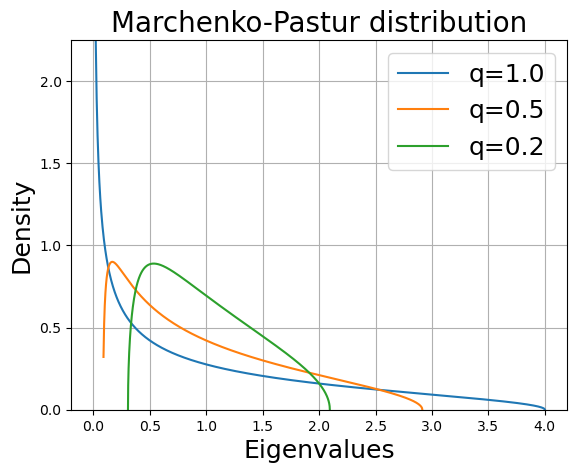

In [26]:
# plot MP pdf
x, y = marchenko_pastur_pdf(1/1)
plt.plot(x, y, label='q=1.0')
x, y = marchenko_pastur_pdf(1/2)
plt.plot(x, y, label='q=0.5')
x, y = marchenko_pastur_pdf(1/5)
plt.plot(x, y, label='q=0.2')
plt.ylim(0, 2.25)
plt.yticks(np.arange(0,2.5,0.5))
plt.title('Marchenko-Pastur distribution', fontsize=20)
plt.xlabel('Eigenvalues', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.legend(fontsize=18)
plt.grid()
plt.savefig('fig1.png')
plt.show()

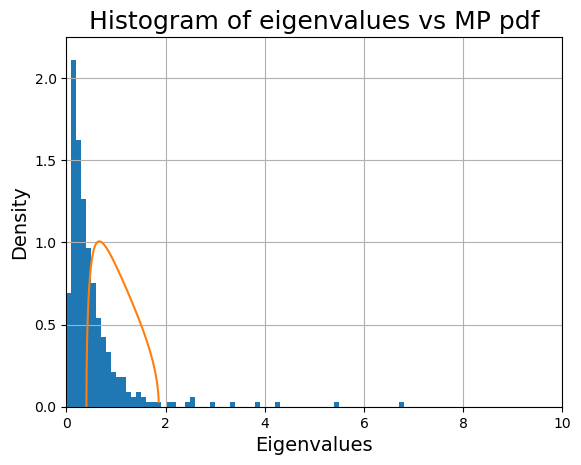

In [27]:
# plot eigval histogram, overlay MP pdf
bin_edges = np.arange(0, 11, 0.1)
plt.hist(eigvals[eigvals <= 10], bins=bin_edges, density=True)
x, y = marchenko_pastur_pdf(q)
plt.plot(x, y)
plt.xlim(0, 10)
plt.xlabel('Eigenvalues', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.ylim(0, 2.25)
plt.yticks(np.arange(0,2.5,0.5))
plt.title('Histogram of eigenvalues vs MP pdf', fontsize=18)
plt.grid()
plt.savefig('fig2.png')
plt.show()

In [28]:
# shuffle each column in A
def shuffle_column(col):
    col_shuffled = np.random.permutation(col)
    return col_shuffled

In [29]:
# compute cutoff point
cutoff = (1+np.sqrt(q))**2
cutoff
print('cutoff=', np.round(cutoff, 2))

cutoff= 1.86


In [30]:
# clip eigenvalues
def clip_eigvals(eigvals, cutoff):
    clipped_eigvals = eigvals.copy()
    mask = eigvals < cutoff  # boolean mask for eigvals below cutoff
    n_below_cutoff = np.sum(mask)  # count number of eigvals below cutoff
    k = np.sum(eigvals[mask]) / np.sum(mask) # compute k so that the trace of C remains unchanged 
    clipped_eigvals[mask] = k  # replace eigvals below cutoff with k
    return clipped_eigvals, k
eigvals_clipped, k = clip_eigvals(eigvals, cutoff)
print('k=', np.round(k, 2))

k= 0.43


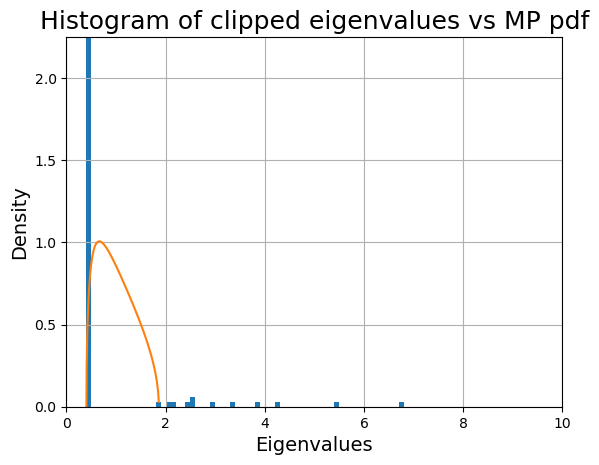

In [31]:
# plot eigval histogram, overlay MP pdf of eigvals of a randomised A
plt.hist(eigvals_clipped[eigvals_clipped <= 10], bins=bin_edges, density=True)
x, y, = marchenko_pastur_pdf(q)
plt.plot(x, y)
plt.xlim(0, 10)
plt.xlabel('Eigenvalues', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.ylim(0, 2.25)
plt.yticks(np.arange(0,2.5,0.5))
plt.title('Histogram of clipped eigenvalues vs MP pdf', fontsize=18)
plt.grid()
plt.savefig('fig3.png')
plt.show()

In [32]:
# reconstruct D from clipped eigenvales
D_clean = np.diag(eigvals_clipped)
assert D_clean[D_clean<k].sum() == 0

In [33]:
# reconstruct C from clipped eigenvales
C_clean = P @ D_clean @ P.T
C_clean = pd.DataFrame(C_clean)

In [34]:
# reconstruct S from C_clean
S_clean = Sigma @ C_clean @ Sigma
S_clean = pd.DataFrame(S_clean)
S_clean.index = A.columns
S_clean.columns = A.columns

In [35]:
# randomise A
A_random = A.apply(shuffle_column, axis=0)
A_random = A_random / A_random.std(axis=0)
S_random = A_random.T @ A_random / (T - 1)
C_random, _ = sample_correlation_matrix(S_random)
eigvals_random, _ = np.linalg.eig(C_random)

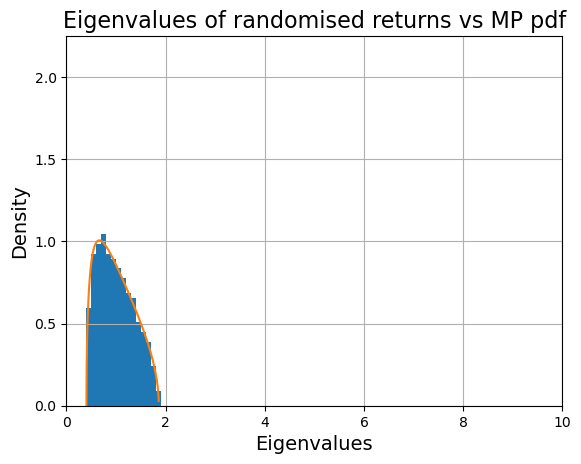

In [36]:
# plot eigval histogram, overlay MP pdf of eigvals of a randomised A
plt.hist(eigvals_random[eigvals_random <= 10], bins=bin_edges, density=True)
x, y, = marchenko_pastur_pdf(q)
plt.plot(x, y)
plt.xlim(0, 10)
plt.xlabel('Eigenvalues', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.ylim(0, 2.25)
plt.yticks(np.arange(0,2.5,0.5))
plt.title('Eigenvalues of randomised returns vs MP pdf', fontsize=16)
plt.grid()
plt.savefig('fig4.png')
plt.show()